In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import json

from collections import defaultdict
from torch.utils.data import DataLoader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
device

device(type='cuda')

In [2]:
def normalize_parameters(loader):
    mean = .0
    std = .0
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, -1)
        mean += images.mean(dim=1).sum().item()
        total_images += batch_samples

    mean /= total_images

    variance = .0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, -1)
        variance += ((images - mean) ** 2).mean(dim=1).sum().item()

    variance /= total_images
    std = variance ** .5

    return mean, std

In [6]:
train_dataset = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)

mean, std = normalize_parameters(train_loader)

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [6]:
train_dataset.__len__()

112800

In [7]:
len_dataset = train_dataset.__len__()
batch_size = 16
total_steps = len_dataset // batch_size
learning_rate = .001
num_classes = train_dataset.classes.__len__()
num_epochs = 5

In [5]:
print(train_dataset.classes[:15])
print(train_dataset.classes.__len__())
print(train_dataset.targets[:15])
print(train_dataset.targets.__len__())

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E']
47
tensor([45, 36, 43, 15,  4, 42, 26, 32, 20,  1, 46, 43, 15, 13, 24])
112800


In [3]:
def get_model(model_name, num_classes):
    if model_name == "resnet18":
        model = models.resnet18(weights="DEFAULT")
        model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16(weights="DEFAULT")
        model.features[0] = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "inception_v3":
        model = models.inception_v3(weights="DEFAULT", aux_logits=True)
        model.Conv2d_1a_3x3.conv = nn.Conv2d(3, 32, kernel_size=3, stride=2, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
    elif model_name == "densenet161":
        model = models.densenet161(weights="DEFAULT")
        model.features.conv0 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, bias=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model.to(device)

In [18]:
summary(get_model("vgg16", num_classes), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [4]:
def save_model(model, model_name, epoch, path="models/", name_data="emnist"):
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, f"{model_name}_{name_data}_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), file_path)
    print(f"Модель {model_name} сохранена в {file_path} после эпохи {epoch+1}")


def load_model(model_name, num_classes, epoch, path="models/", name_data="emnist"):
    model = get_model(model_name, num_classes)
    file_path = os.path.join(path, f"{model_name}_{name_data}_epoch_{epoch}.pth")
    model.load_state_dict(torch.load(file_path, map_location=device))
    model.to(device)
    print(f"Модель {model_name} загружена из {file_path}")
    return model


def save_results_to_json(results, path="models/", filename="results.json"):
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, filename)
    with open(file_path, 'w') as f:
        json.dump(dict(results), f, indent=4)
    print(f"Результаты сохранены в {file_path}")


def train_model(model, train_loader, num_epochs, model_name, name_data="emnist"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        start = time.time()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            if model_name == "inception_v3" and model.training:
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + .4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % (total_steps // 2) == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}.")

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        loss_history.append(avg_loss)
        print(f'Time {time.time() - start} sec, {model_name} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

        save_model(model, model_name, epoch, name_data=name_data)

    return loss_history


def test_model(model, test_loader, model_name, name_data="emnist"):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    print(f'{model_name} Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [7]:
transform_normalized_others = transforms.Compose([
    tv.transforms.Grayscale(3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset_normalized_others = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform_normalized_others,
    download=False
)

test_dataset_normalized_others = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform_normalized_others,
    download=False
)

transform_normalized_inception = transforms.Compose([
    tv.transforms.Grayscale(3),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset_normalized_inception = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform_normalized_inception,
    download=False
)

test_dataset_normalized_inception = tv.datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform_normalized_inception,
    download=False
)

In [8]:
train_loader_others = DataLoader(dataset=train_dataset_normalized_others, batch_size=batch_size, shuffle=True)
test_loader_others = DataLoader(dataset=test_dataset_normalized_others, batch_size=batch_size, shuffle=False)

train_loader_inception = DataLoader(dataset=train_dataset_normalized_inception, batch_size=batch_size, shuffle=True)
test_loader_inception = DataLoader(dataset=test_dataset_normalized_inception, batch_size=batch_size, shuffle=False)

In [9]:
model_names = ['inception_v3', "densenet161", "resnet18", "vgg16"]
results = defaultdict(list)

for model_name in model_names:
    print(f"\nTraining {model_name}...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = get_model(model_name, num_classes)

    train_loader = train_loader_others if model_name != 'inception_v3' else train_loader_inception
    test_loader = test_loader_others if model_name != 'inception_v3' else test_loader_inception

    loss_history = train_model(model, train_loader, num_epochs, model_name)
    test_loss, test_accuracy = test_model(model, test_loader, model_name)

    results['Model'].append(model_name)
    results['Test Loss'].append(test_loss)
    results['Test Accuracy'].append(test_accuracy)
    results['Train Loss History'].append(loss_history)

    save_results_to_json(results)


Training inception_v3...
Step 0. time since epoch: 0.488.
Step 3525. time since epoch: 484.232.
Time 974.2200047969818 sec, inception_v3 Epoch [1/5], Loss: 0.7493, Accuracy: 81.77%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_1.pth после эпохи 1
Step 0. time since epoch: 0.140.
Step 3525. time since epoch: 492.437.
Time 985.2813060283661 sec, inception_v3 Epoch [2/5], Loss: 0.5060, Accuracy: 87.02%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_2.pth после эпохи 2
Step 0. time since epoch: 0.147.
Step 3525. time since epoch: 491.156.
Time 980.873610496521 sec, inception_v3 Epoch [3/5], Loss: 0.4368, Accuracy: 88.49%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_3.pth после эпохи 3
Step 0. time since epoch: 0.141.
Step 3525. time since epoch: 494.984.
Time 983.0786068439484 sec, inception_v3 Epoch [4/5], Loss: 0.3962, Accuracy: 89.36%
Модель inception_v3 сохранена в models/inception_v3_emnist_epoch_4.pth после эпохи 4
Step 0. tim

100.0%


Step 0. time since epoch: 0.252.
Step 3525. time since epoch: 785.917.
Time 1571.9584267139435 sec, vgg16 Epoch [1/5], Loss: 3.8596, Accuracy: 2.09%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_1.pth после эпохи 1
Step 0. time since epoch: 0.237.
Step 3525. time since epoch: 785.733.
Time 1571.0589008331299 sec, vgg16 Epoch [2/5], Loss: 3.8531, Accuracy: 2.15%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_2.pth после эпохи 2
Step 0. time since epoch: 0.226.
Step 3525. time since epoch: 785.527.
Time 1571.035100698471 sec, vgg16 Epoch [3/5], Loss: 3.8522, Accuracy: 2.11%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_3.pth после эпохи 3
Step 0. time since epoch: 0.228.
Step 3525. time since epoch: 785.869.
Time 1571.1184408664703 sec, vgg16 Epoch [4/5], Loss: 3.8516, Accuracy: 2.06%
Модель vgg16 сохранена в models/vgg16_emnist_epoch_4.pth после эпохи 4
Step 0. time since epoch: 0.226.
Step 3525. time since epoch: 815.627.
Time 1650.6189801692963 sec, vgg16 Epoch [5/5], Lo

In [20]:
results = json.load(open("models/results.json", "r"))
results

{'Model': ['inception_v3', 'densenet161', 'resnet18', 'vgg16'],
 'Test Loss': [0.29807768354033853,
  0.29605619810799017,
  0.29922586611491886,
  3.850429276608406],
 'Test Accuracy': [89.87234042553192,
  89.42021276595744,
  89.77127659574468,
  2.127659574468085],
 'Train Loss History': [[0.7493070539731718,
   0.5059589272676736,
   0.4368141402766531,
   0.396155225706835,
   0.36611326971025276],
  [0.5247066387293715,
   0.3555591437400233,
   0.3061056768488641,
   0.277782747976297,
   0.25916939397656247],
  [0.4931526808377276,
   0.34357562259671853,
   0.29176048510866437,
   0.2574718098265799,
   0.2312212653930715],
  [3.859637698078832,
   3.853110141449786,
   3.852206782313949,
   3.8515525586216164,
   3.8513797113743236]]}

In [21]:
df = pd.DataFrame({
    'Model': results['Model'],
    'Test Loss': [f"{x:.4f}" for x in results['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model Test Loss Test Accuracy (%)
0  inception_v3    0.2981             89.87
1   densenet161    0.2961             89.42
2      resnet18    0.2992             89.77
3         vgg16    3.8504              2.13


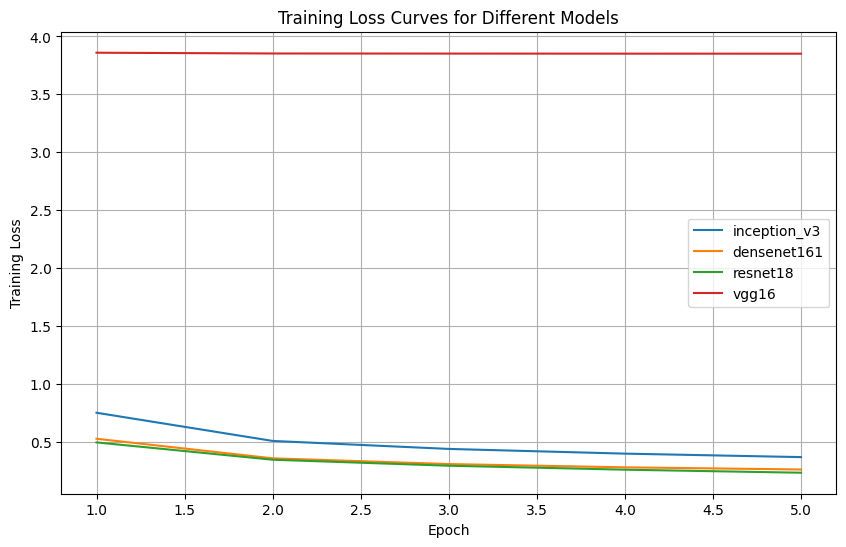

In [22]:
plt.figure(figsize=(10, 6))
for model_name, loss_history in zip(results['Model'], results['Train Loss History']):
    plt.plot(range(1, num_epochs + 1), loss_history, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

**Dataset Hymenoptera**

In [5]:
import kagglehub

path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

/home/borealis/Documents/study/Netology/dll/homeworks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
image_size = (300, 300)

train_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/train'),
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
)

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)

mean, std = normalize_parameters(train_loader)

In [7]:
len_dataset = train_dataset.__len__()
batch_size = 8
total_steps = len_dataset // batch_size
learning_rate = .001
num_classes = train_dataset.classes.__len__()
num_epochs = 30

In [8]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])


train_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/train'),
    transform=transform
)

test_dataset = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/val'),
    transform=transform
)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
transform_normalized = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


train_dataset_normalized = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/train'),
    transform=transform_normalized
)

test_dataset_normalized = tv.datasets.ImageFolder(
    root=os.path.join(path, 'hymenoptera_data/val'),
    transform=transform_normalized
)


train_loader_normalized = DataLoader(dataset=train_dataset_normalized, batch_size=batch_size, shuffle=True)
test_loader_normalized = DataLoader(dataset=test_dataset_normalized, batch_size=batch_size, shuffle=False)

In [10]:
model_names = ["densenet161", 'inception_v3', "resnet18", "vgg16"]
loaders = [
    (train_loader, test_loader),
    (train_loader_normalized, test_loader_normalized)
]
results = defaultdict(list)

for model_name in model_names:
    for train_loader, test_loader in loaders:
        print(f"\nTraining {model_name}...")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        model = get_model(model_name, num_classes)

        loss_history = train_model(model, train_loader, num_epochs, model_name, name_data="hymenoptera")
        test_loss, test_accuracy = test_model(model, test_loader, model_name, name_data="hymenoptera")

        results['Dataset'].append("hymenoptera")
        results['Normalized'].append(train_loader == train_loader_normalized)
        results['Model'].append(model_name)
        results['Test Loss'].append(test_loss)
        results['Test Accuracy'].append(test_accuracy)
        results['Train Loss History'].append(loss_history)

        save_results_to_json(results, filename="results_hymenoptera.json")


Training densenet161...
Step 0. time since epoch: 0.527.
Step 15. time since epoch: 3.742.
Step 30. time since epoch: 6.919.
Time 6.919689893722534 sec, densenet161 Epoch [1/30], Loss: 0.7331, Accuracy: 53.69%
Модель densenet161 сохранена в models/densenet161_hymenoptera_epoch_1.pth после эпохи 1
Step 0. time since epoch: 0.248.
Step 15. time since epoch: 3.401.
Step 30. time since epoch: 6.449.
Time 6.452175855636597 sec, densenet161 Epoch [2/30], Loss: 0.8050, Accuracy: 57.79%
Модель densenet161 сохранена в models/densenet161_hymenoptera_epoch_2.pth после эпохи 2
Step 0. time since epoch: 0.212.
Step 15. time since epoch: 3.403.
Step 30. time since epoch: 6.467.
Time 6.467060327529907 sec, densenet161 Epoch [3/30], Loss: 0.7132, Accuracy: 52.05%
Модель densenet161 сохранена в models/densenet161_hymenoptera_epoch_3.pth после эпохи 3
Step 0. time since epoch: 0.209.
Step 15. time since epoch: 3.377.
Step 30. time since epoch: 6.479.
Time 6.47925066947937 sec, densenet161 Epoch [4/30],

In [11]:
df = pd.DataFrame({
    'Model': results['Model'],
    'Normalized': results['Normalized'],
    'Test Loss': [f"{x:.4f}" for x in results['Test Loss']],
    'Test Accuracy (%)': [f"{x:.2f}" for x in results['Test Accuracy']]
})
print("\nResults Table:")
print(df)


Results Table:
          Model  Normalized Test Loss Test Accuracy (%)
0   densenet161       False    0.5731             73.86
1   densenet161        True    0.5498             71.24
2  inception_v3       False    0.6007             74.51
3  inception_v3        True    0.9897             66.01
4      resnet18       False    1.6056             62.09
5      resnet18        True    0.6540             72.55
6         vgg16       False    0.7181             45.75
7         vgg16        True    0.6876             54.25


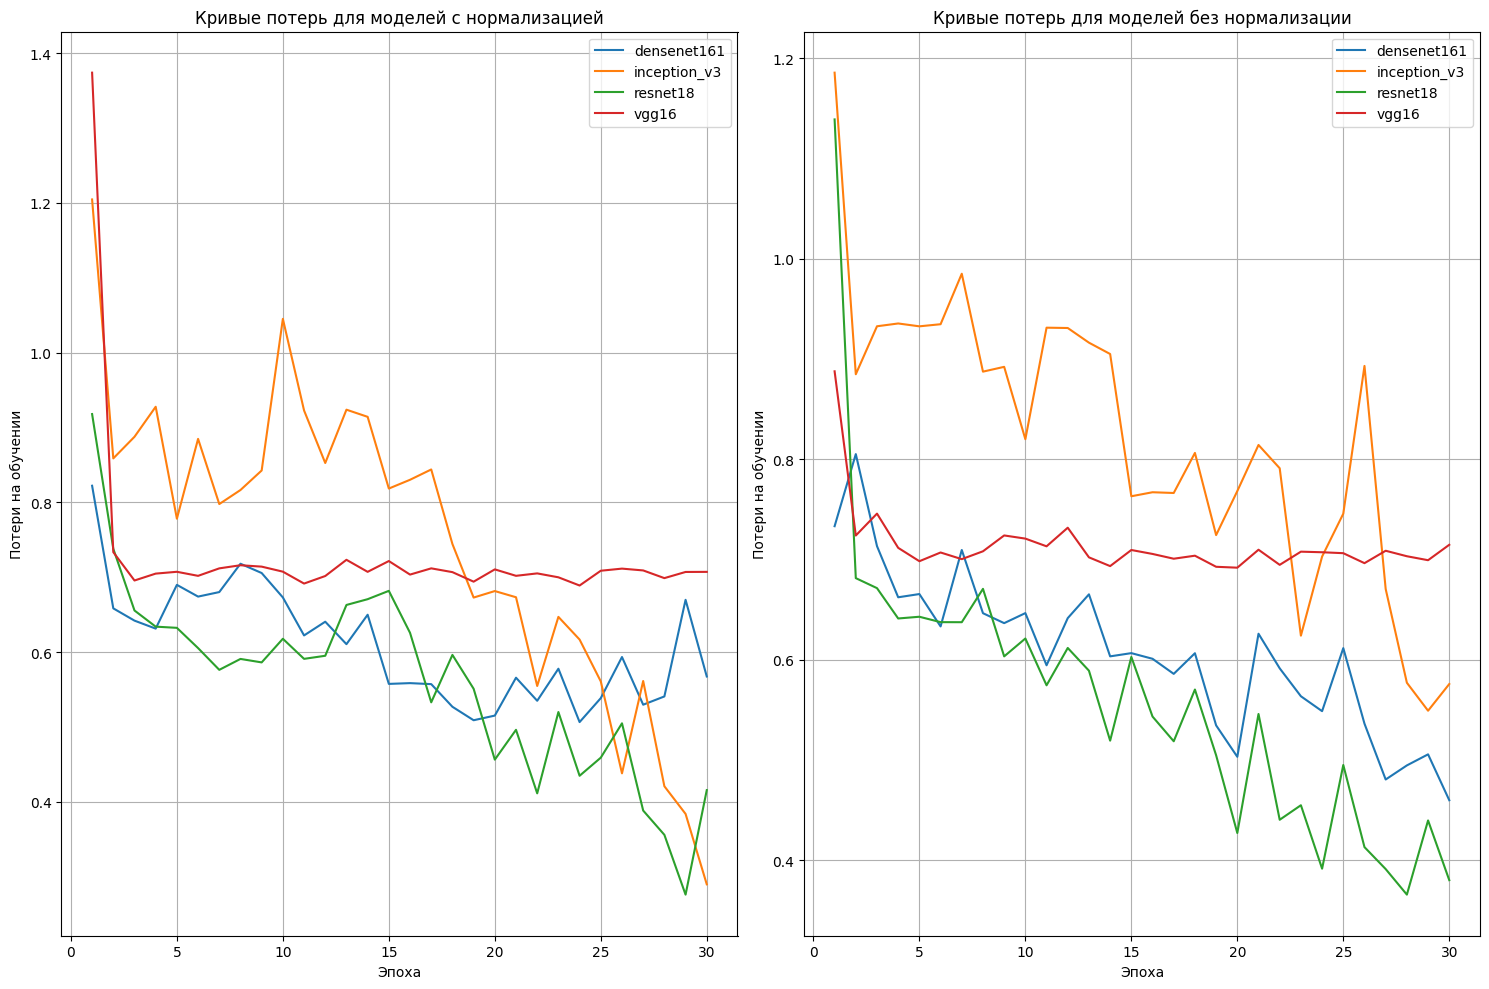

In [15]:
plt.figure(figsize=(15, 10))

# График для моделей с Normalized=True
plt.subplot(1, 2, 1)
for model_name, loss_history, normalized in zip(results['Model'], results['Train Loss History'], results['Normalized']):
    if normalized:
        plt.plot(range(1, num_epochs + 1), loss_history, label=model_name)
plt.xlabel('Эпоха')
plt.ylabel('Потери на обучении')
plt.title('Кривые потерь для моделей с нормализацией')
plt.legend()
plt.grid(True)

# График для моделей с Normalized=False
plt.subplot(1, 2, 2)
for model_name, loss_history, normalized in zip(results['Model'], results['Train Loss History'], results['Normalized']):
    if not normalized:
        plt.plot(range(1, num_epochs + 1), loss_history, label=model_name)
plt.xlabel('Эпоха')
plt.ylabel('Потери на обучении')
plt.title('Кривые потерь для моделей без нормализации')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()